# Difference in Difference

- The discount was not randomly assigned.
- At some point in time, the e-commerce company started giving discount coupons to women on Mother’s Day.
- At some point in time, the company started testing more aggressive discounting in the state MG.

In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

import statsmodels.formula.api as smf

In [15]:
df = pd.read_csv("./diff_in_diff.csv")
df.head()

,sales,discount,age,gender,cust_state,tenure,profit,month
0,1153.28,0,25,O,MA,19,57.66,7
1,1978.13,0,26,M,MG,16,98.91,6
2,1095.70,0,26,W,RJ,20,54.78,2
3,2404.90,25,30,W,BA,18,95.24,6
4,1704.80,0,38,M,PB,15,85.24,4


In [3]:
df.dtypes

sales         float64
discount        int64
age             int64
gender         object
cust_state     object
tenure          int64
profit        float64
month           int64
dtype: object

In [16]:
df.isna().mean()

sales         0.0000
discount      0.0000
age           0.0000
gender        0.0993
cust_state    0.0000
tenure        0.0000
profit        0.0000
month         0.0000
dtype: float64

In [17]:
df["is_w"] = np.where(df["gender"] == "W", 1, 0)

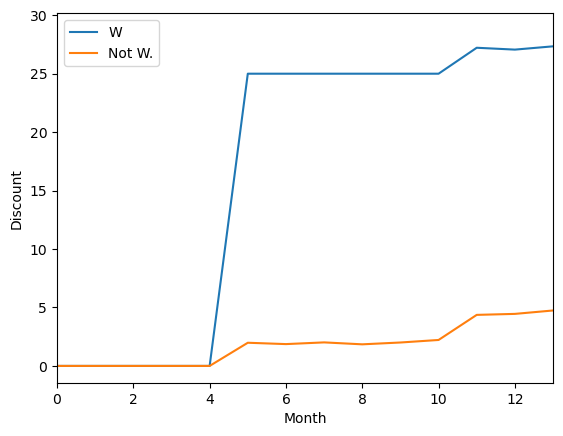

In [7]:
df_plt = df.groupby(["month", "is_w"])["discount"].mean().reset_index()

plt.plot(df_plt.query("is_w==1")["month"], df_plt.query("is_w==1")["discount"], label="W")
plt.plot(df_plt.query("is_w==0")["month"], df_plt.query("is_w==0")["discount"], label="Not W.")
plt.xlim(0, 13)
plt.ylabel("Discount")
plt.xlabel("Month")
plt.legend();

We can see a sharp increase in women's discounts at month five. This does not happen to men.
 
### Checking discounts across states by month


In [8]:
state_df = df.groupby(["month", "cust_state"])[["profit", "discount"]].mean().reset_index()

state_df.head()

,month,cust_state,profit,discount
0,0,AC,42.190000,0.0
1,0,AL,55.047647,0.0
2,0,AM,62.797273,0.0
3,0,AP,63.494000,0.0
4,0,BA,67.307551,0.0


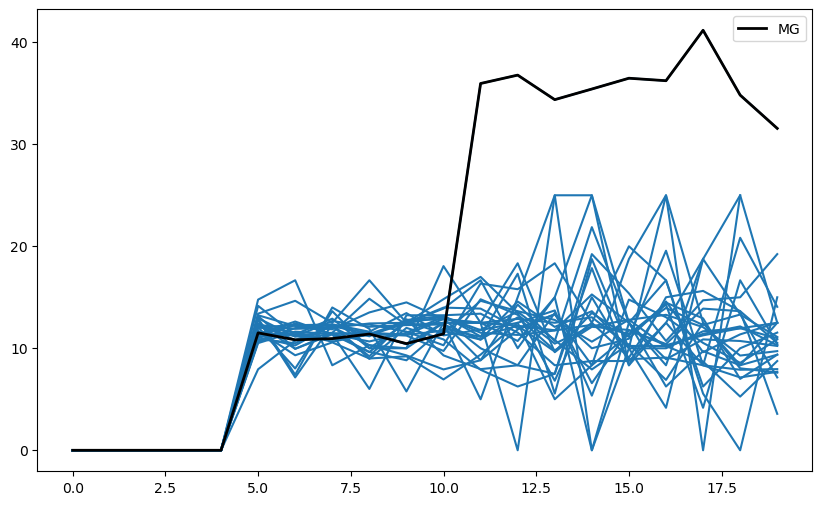

In [9]:
plt.figure(figsize=(10,6))

for state in state_df["cust_state"].unique():
    plt.plot(state_df.query(f"cust_state == '{state}'")["month"],
             state_df.query(f"cust_state == '{state}'")["discount"], c="C0")
    
plt.plot(state_df.query("cust_state == 'MG'")["month"],
         state_df.query("cust_state == 'MG'")["discount"], label="MG", lw=2, color="black")

plt.legend();

We can also see a sharp increase in discount for the state of MG on month 11. 
 
## Before and After Comparison in Treated Group
 


After month 5, the e-commerce company started giving \$25 discounts for women on mother's day. Hence, the post intervention period is after month 5. Also, since only women were contemplated by the mother's day discount, they are the treated group. 

In [43]:
df_diff_in_diff = (df.assign(post_intervention = df["month"] >= 5)
                     .assign(treated = df["is_w"] == 1))

In [44]:
df_diff_in_diff.head()

,sales,discount,age,gender,cust_state,tenure,profit,month,is_w,post_intervention,treated
0,1153.28,0,25,O,MA,19,57.66,7,0,True,False
1,1978.13,0,26,M,MG,16,98.91,6,0,True,False
2,1095.70,0,26,W,RJ,20,54.78,2,1,False,True
3,2404.90,25,30,W,BA,18,95.24,6,1,True,True
4,1704.80,0,38,M,PB,15,85.24,4,0,False,False


In [38]:
treated_after = (df_diff_in_diff
                 .query("treated")
                 .query("post_intervention")
                 ["profit"]
                 .mean())


treated_before = (df_diff_in_diff
                  .query("treated")
                  .query("~post_intervention")
                  ["profit"]
                  .mean())

treated_after - treated_before

7.141746279890299

After the intervention period, the woman's profit increased by \$7.14. In other words
 
$$
E[Y|Gender=W, Period=1] - E[Y|Gender=W, Period=0] = 7.14
$$
 
- We can interpret this as the average causal effect of the discount on profit **only if woman's profit is not changing with time**.
- But that assumption would be violated if women’s profits were not stationary, that is, if it was growing or decreasing over time.

 
### Treatement vs. Control after Intervention

In [45]:
control_after = (df_diff_in_diff
                 .query("~treated")
                 .query("post_intervention")
                 ["profit"]
                 .mean())

treated_after - control_after

-7.124377132193672

After the intervention period, the treated (woman's) profit is \$7.12 **lower** than the untreated (men) group. That is,
 
$$
E[Y|Gender=W, Period=1] - E[Y|Gender=M, Period=1] = -7.12
$$
 
- We can interpret this as the average causal effect of the discount on profit **only if woman's would the same profit as men's if there were no discount for woman**.
- But that assumption would be violated if women’s profits were on another level than men’s.


## Checking Difference in Differences assumptions

- Both these assumptions are very strong. 
- Diff in diff only assumes that men and women have similar growth trajectories. 
- They don’t have to be on the same level or stationary.

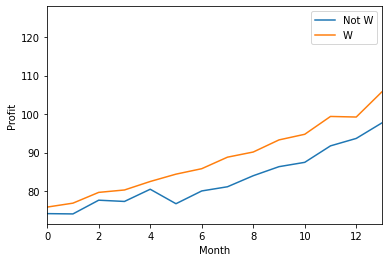

In [13]:
df_plt = df.groupby(["month", "is_w"])["profit"].mean().reset_index()

plt.plot(df_plt.query("is_w==1")["month"], df_plt.query("is_w==1")["profit"], label="Not W")
plt.plot(df_plt.query("is_w==0")["month"], df_plt.query("is_w==0")["profit"], label="W")
plt.xlim(0, 13)
plt.ylabel("Profit")
plt.xlabel("Month")
plt.legend();

- Treated and control groups seem to have parallel trends, aside for when the intervention takes place (month 5). 
- However, men's profit is overall less than women's profit, so the assumption that men's & women's profit are same is not valid. 
- Also, women's profit seems to be increasing over time, so wome's profit is not stationary
 
 
### Estimating diff in diff emperically

In [47]:
control_before = (df_diff_in_diff
                  .query("~treated")
                  .query("~post_intervention")
                  ["profit"]
                  .mean())

#diff in diff

(treated_after - treated_before) - (control_after - control_before)

-4.7735016421366225

### Estimating diff in diff using regression

In [51]:
smf.ols('profit ~ treated*post_intervention', data=df_diff_in_diff).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,80.5275,0.342,235.715,0.000,79.858,81.197
treated[T.True],-2.3509,0.532,-4.421,0.000,-3.393,-1.309
post_intervention[T.True],11.9152,0.402,29.673,0.000,11.128,12.702
treated[T.True]:post_intervention[T.True],-4.7735,0.625,-7.642,0.000,-5.998,-3.549


The interaction coefficient is numerically identical to the diff-in-diff estimator we've estimated by hand. This diff-in-diff estimator can be interpreted as the causal effect if men's and women's profit have similar growth trajectories (parallel trends). This is a much weaker assumption than he same level or stationary
 
That is, if the treatment effect of giving \$ 25 in discount is -4.77, things are not looking good for the discount product. This means that, for every \$1.00 in discount, we expect to lose about \$0.20. 

## Synthetic Control
- Difference in differences works if we have a control group with a similar growth trajectory. But what if we don’t have such a control?
- We can combine mutiple controls and build a synthetic control that just behaves like treated group in the preintervention period.
### State MG is the treated group

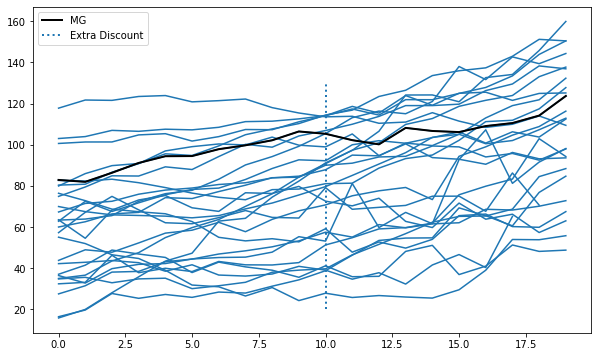

In [16]:
plt.figure(figsize=(10,6))

for state in state_df["cust_state"].unique():
    plt.plot(state_df.query(f"cust_state == '{state}'")["month"],
             state_df.query(f"cust_state == '{state}'")["profit"], c="C0")
    
plt.plot(state_df.query("cust_state == 'MG'")["month"],
         state_df.query("cust_state == 'MG'")["profit"], label="MG", lw=2, color="black")

plt.vlines(x=10, ymin=20, ymax=130, linestyle=":", lw=2, label="Extra Discount")

plt.legend();

Notice that we have many states and multiple time periods. So there isn't a clear control we can compare against the treated state, MG.
 
 


In [13]:
inverted = (state_df
            .pivot(index='cust_state', columns="month")["profit"] # make one column per year and one row per state
            .fillna(0)
            .T) # flip the table to have one column per state

inverted_pre = inverted[inverted.index < 11]
inverted_pre

cust_state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
month,,,,,,,,,,,,,,,,,,,,,
0,42.190000,55.047647,62.797273,63.494000,67.307551,79.947778,15.791429,80.367273,117.773462,82.661935,...,74.887059,69.956111,63.357000,43.776667,57.260000,34.999444,27.495625,16.405000,103.014244,37.040000
1,42.866000,51.954800,72.500000,54.530000,71.463093,85.956667,19.945625,80.817200,121.725758,82.319318,...,79.460299,67.488941,63.868947,48.931429,67.148000,36.594308,31.455455,19.660000,103.956466,41.450000
2,43.717143,46.515135,67.556275,68.231667,72.513684,89.837619,28.060938,86.637955,121.561389,83.237867,...,84.896723,65.903920,65.550698,47.741579,74.894286,43.493920,38.083846,27.690455,106.974268,48.804375
3,42.665455,44.704032,71.761605,73.148889,75.950916,90.885620,35.793043,90.811477,123.448310,81.540486,...,84.782019,65.616638,72.470250,52.260937,68.352500,47.541168,38.429041,25.347059,106.514163,46.877778
4,38.514000,38.983294,75.687207,75.322500,77.949444,95.577831,43.432821,96.985339,123.895369,79.171152,...,89.253986,65.287454,76.204337,57.030682,62.072500,54.860063,43.115078,27.216154,107.545872,45.217353
5,41.649310,31.797368,78.271926,69.351786,78.952319,94.778441,47.277660,99.057559,120.839486,76.483467,...,87.948212,64.472000,77.841933,58.454667,61.603636,59.706278,44.414685,25.810875,107.225881,37.867500
6,36.657037,30.944731,78.913917,67.600000,80.666347,99.432095,62.873523,100.371389,121.417048,74.451179,...,94.249459,65.543528,83.237983,62.283774,64.559333,63.646376,46.875233,28.390714,108.470502,42.945490
7,36.162400,26.473636,83.099060,76.647000,81.501328,104.863297,64.232796,99.888250,122.207006,73.252598,...,100.197857,68.812020,90.171667,57.726970,68.001905,70.021509,48.431675,27.899589,111.223821,40.630385
8,37.150000,30.585846,88.439079,76.303810,83.881258,107.663279,74.505429,103.699500,118.027143,78.157818,...,98.802412,71.648874,94.235135,63.720400,64.678824,76.161011,50.369689,31.233208,111.441579,39.010800


As we can see, we now have a dataset where the rows are the time periods and the columns are the states. Each value is the average profit for that particular month and state. 


In [61]:
#fit an elsatic net model as number of features is high and number of rows are low
from sklearn.linear_model import ElasticNet


y = inverted_pre["MG"].values 
X = inverted_pre.drop(columns="MG").values


model_synth = ElasticNet(alpha=50, fit_intercept=False, max_iter=10000).fit(X, y)

weights = model_synth.coef_

weights

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.15666702, 0.06709938, 0.15451208, 0.14239844, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.11871068,
       0.        , 0.08386732, 0.        , 0.11140646, 0.        ,
       0.        , 0.00979641, 0.        , 0.        , 0.13232692,
       0.        ])

In [72]:
states = []
for x,y in zip(inverted_pre.drop(columns="MG").columns,weights):
    if y != 0:
        states.append(x)

print(states)


['CE', 'DF', 'ES', 'GO', 'PE', 'PR', 'RN', 'RS', 'SP']


Using ElasticNet, we can find weights such that we can build our synthetic control in a way that approximates the treated unit, MG, in the pre-intervention period.
 
$$
Profit_{mg} \approx \sum^S_{s=0} w_s * Profit_s
$$
 
We can even see which states we are combining to make our synthetic control. For instance we are only using states CE, DF, ES, GO, PE, PR, RN, RS and SP in the combination. All other weights are zero.


In [19]:
pd.DataFrame(dict(state=inverted.drop(columns="MG").columns, weights=weights))

,state,weights
0,AC,0.000000
1,AL,0.000000
2,AM,0.000000
3,AP,0.000000
4,BA,0.000000
5,CE,0.156667
6,DF,0.067099
7,ES,0.154512
8,GO,0.142398
9,MA,0.000000


In [74]:
#fitted value for synthetic control
synth = inverted.drop(columns=["MG"]).fillna(0).values.dot(weights)

synth

array([ 82.03056215,  84.54879919,  87.689239  ,  90.43252607,
        93.76770244,  93.43824919,  97.0876573 , 100.1759432 ,
       101.71088524, 103.36191277, 105.74886091, 109.68786782,
       109.17020599, 114.17917446, 115.04636528, 117.5955818 ,
       118.11083301, 121.99262304, 126.39896116, 128.03030073])

### Synthetic Control vs. Treated Comparison (Profit)

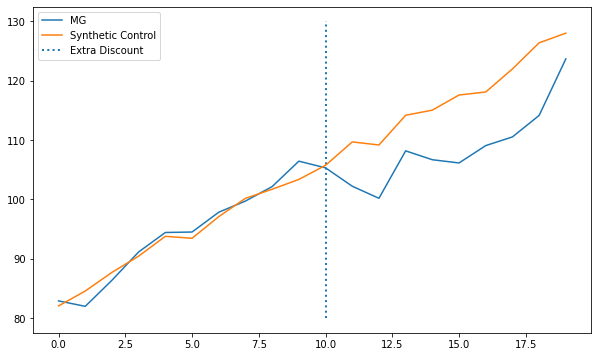

In [21]:
plt.figure(figsize=(10,6))
plt.plot(state_df.query(f"cust_state == 'MG'")["month"], state_df.query(f"cust_state == 'MG'")["profit"], label="MG")
plt.plot(state_df.query(f"cust_state == 'MG'")["month"], synth, label="Synthetic Control")
plt.vlines(x=10, ymin=80, ymax=130, linestyle=":", lw=2, label="Extra Discount")

plt.legend();

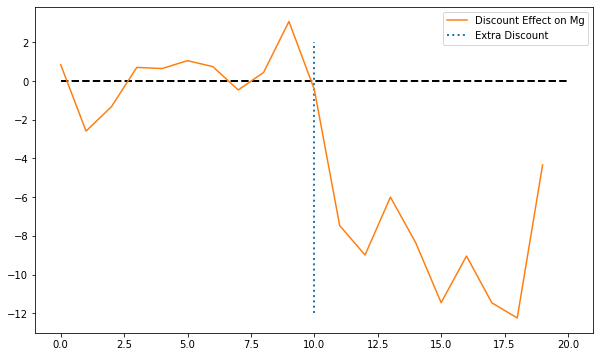

In [22]:
plt.figure(figsize=(10,6))
plt.plot(state_df.query(f"cust_state == 'MG'")["month"],
         state_df.query(f"cust_state == 'MG'")["profit"] - synth, label="Discount Effect on Mg",
         c="C1"
        )

plt.vlines(x=10, ymin=-12, ymax=2, linestyle=":", lw=2, label="Extra Discount")
plt.hlines(y=0, xmin=0, xmax=20, linestyle="--", lw=2, color="black")

plt.legend();

- We can see that the profit of synthetic control keeps growing after the intervention, while the profit for the state of MG takes a dip. This means that, after increasing the discount, the state became less profitable.
 
- Conclusion: If we plot the difference between them, we can see the effect of discounts on profits over time. Again, we conclude that the effect is negative, meaning that discount is not profitable.